In [1]:
%matplotlib inline
#
import sys; sys.path.insert(0, "..")
from multifunbrain import *
#
if '_dir_changed' not in globals():
    path_root = Path.cwd().parent
path_data =  path_root / Path("data")
path_atlas_timecourses = path_data / Path("atlas_timecourses")
path_correlation_matrices = path_data / Path("correlation_matrices")
path_neuroplots = path_data / Path("neuroplots")
#
if '_dir_changed' not in globals():
    os.chdir(path_root)
    _dir_changed = True
print(f"Current working directory: {Path.cwd()}")

Current working directory: /home/opisthofulax/Documents/UniPa/projects/multifun-brain


### Atlas setup

In [2]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm', data_dir=path_data)
atlas_filename = atlas.maps
atlas_img = image.load_img(atlas_filename)
atlas_data = atlas_img.get_fdata()
#
rois = atlas.labels
rois_label_map = {i: ll for i,ll in enumerate(rois[1:])}
roi_indices = np.unique(list(rois_label_map.keys()))
#
template = load_mni152_template()

[get_dataset_dir] Dataset found in /home/opisthofulax/Documents/UniPa/projects/multifun-brain/data/fsl


In [3]:
slow5_min = 0.01
slow5_max = 0.073
#
f_test_min = 0.01
f_test_max = 0.18
#
slow4_min = slow5_max
slow4_max = f_test_max
#

In [4]:
contrast_keys = ["CBF_ASL", "CBV_VASO", "BOLD", "BOLD_RS"]
contrast_suffix = ["CBF4D", "fcurN_Vaso", "furN_Bold", "optcomMIRDenoised_bold"]
sampling_frequency_vals = [1/5.5, 1/1.353, 1/1.353, 1/0.98]
#
file_names_dict = {dk: f"HarvardOxford_48Parcels_kw{sf}.ts.1D"
                   for dk, sf in zip(contrast_keys, contrast_suffix)}
sampling_frequency_dict = {dk: fs 
                           for dk, fs in zip(contrast_keys, sampling_frequency_vals)}
contrast_dict = {dk: dict(
    file_name=file_names_dict[dk], 
    freq=sampling_frequency_dict[dk])
    for dk in contrast_keys 
}

### Results with the Slow-4/5 Band

In [5]:
subject_folders = [f for f in path_atlas_timecourses.iterdir() if f.is_dir() and f.name.startswith("sub-")]

In [6]:
for subject_folder in subject_folders:
    #
    subject_id = subject_folder.name
    subject_results_dir = path_correlation_matrices / subject_id
    subject_results_dir.mkdir(parents=True, exist_ok=True)
    #
    for dk in contrast_keys:
        file_path = subject_folder / contrast_dict[dk]["file_name"]
        file_out_corr_slow4 = subject_results_dir / f"corr_slow4_{dk}.npy"
        file_out_corr_slow5 = subject_results_dir / f"corr_slow5_{dk}.npy"
        file_out_corr_test = subject_results_dir / f"corr_test_{dk}.npy"
        if file_path.exists() and (not file_out_corr_slow4.exists() or not file_out_corr_slow5.exists() or not file_out_corr_test.exists()):
            ts_original = np.loadtxt(file_path)
            num_timepoints, num_rois = ts_original.shape
            #
            ts_slow5 = np.zeros_like(ts_original)
            ts_slow4 = np.zeros_like(ts_original)
            ts_ftest = np.zeros_like(ts_original)
            #
            # Compute FFT for all ROIs along axis 0
            fft_all = np.fft.fft(ts_original, axis=0)
            frequencies = np.fft.fftfreq(num_timepoints, d=1/contrast_dict[dk]["freq"])
            abs_freq = np.abs(frequencies)

            # Create vectorized masks for the frequency bands
            mask_slow5 = (abs_freq >= slow5_min) & (abs_freq <= slow5_max)
            mask_slow4 = (abs_freq >= slow4_min) & (abs_freq <= slow4_max)
            mask_ftest = (abs_freq >= f_test_min) & (abs_freq <= f_test_max)
            # Apply masks and compute inverse FFT for each frequency band across all ROIs
            ts_slow5 = np.real(np.fft.ifft(fft_all * mask_slow5[:, None], axis=0))
            ts_slow4 = np.real(np.fft.ifft(fft_all * mask_slow4[:, None], axis=0))
            ts_ftest = np.real(np.fft.ifft(fft_all * mask_ftest[:, None], axis=0))
            corr_matrix_slow5 = np.corrcoef(ts_slow5.T)
            corr_matrix_slow4 = np.corrcoef(ts_slow4.T)
            corr_matrix_test = np.corrcoef(ts_ftest.T)
            np.save(file_out_corr_slow5, corr_matrix_slow5)
            np.save(file_out_corr_slow4, corr_matrix_slow4)
            np.save(file_out_corr_test, corr_matrix_test)
            print(f"Saved: {file_out_corr_slow4}, {file_out_corr_slow5}, {file_out_corr_test}", end="\r")
        elif file_out_corr_slow4.exists() and file_out_corr_slow5.exists():
            print(f"Already exists: {file_out_corr_slow4}, {file_out_corr_slow5}", end="\r")
        else:
            print(f"Not found: {file_path}",end="\r")

In [7]:
mean_corr_slow4 = {}
mean_corr_slow5 = {}
mean_corr_test = {}
for dk in contrast_keys:
    mean_corr_slow4[dk] = []
    mean_corr_slow5[dk] = []
    mean_corr_test[dk] = []
    for subject_folder in subject_folders:
        subject_id = subject_folder.name
        subject_results_dir = path_correlation_matrices / subject_id
        file_in_corr_slow4 = subject_results_dir / f"corr_slow4_{dk}.npy"
        file_in_corr_slow5 = subject_results_dir / f"corr_slow5_{dk}.npy"
        file_in_corr_test = subject_results_dir / f"corr_test_{dk}.npy"
        if file_in_corr_slow4.exists() and file_in_corr_slow5.exists() and file_in_corr_test.exists():
                    corr_slow4 = np.load(file_in_corr_slow4)
                    corr_slow5 = np.load(file_in_corr_slow5)
                    corr_test = np.load(file_in_corr_test)
                    mean_corr_slow4[dk].append(corr_slow4)
                    mean_corr_slow5[dk].append(corr_slow5)
                    mean_corr_test[dk].append(corr_test)
    mean_corr_slow4[dk] = np.mean(mean_corr_slow4[dk], axis=0)
    mean_corr_slow5[dk] = np.mean(mean_corr_slow5[dk], axis=0)
    mean_corr_test[dk] = np.mean(mean_corr_test[dk], axis=0)

In [8]:
corr_arr_dict = {'mean_corr_slow4': mean_corr_slow4,
                 'mean_corr_slow5': mean_corr_slow5,
                 'mean_corr_test': mean_corr_test}

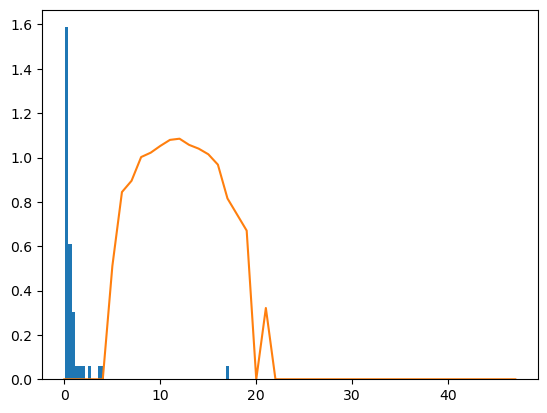

In [9]:
dk = "CBV_VASO"
corr = np.loadtxt(subject_folders[0] / contrast_dict[dk]["file_name"])
tsteps = corr.shape[0]
gamma = corr.shape[1]/tsteps
eigvals = np.linalg.eigvals(mean_corr_slow4["BOLD"])
mp_dist = marchenko_pastur(eigvals, gamma)
plt.hist(eigvals, bins=50, density=True)
plt.plot(mp_dist)

### Correlation Networks Analysis

In [10]:
corr_arr_dict.keys(), contrast_keys

(dict_keys(['mean_corr_slow4', 'mean_corr_slow5', 'mean_corr_test']),
 ['CBF_ASL', 'CBV_VASO', 'BOLD', 'BOLD_RS'])

In [21]:
for dk in contrast_keys:
    corr_arr_str = "mean_corr_slow5"
    graph_threshold = 0.1
    pinf_threshold = 1-0.01
    corr_arr = corr_arr_dict[corr_arr_str][dk]
    G, _ = build_correlation_network(corr_arr)
    Th, Einf, Pinf = compute_threshold_stats(G)
    cross_idx = np.where((Pinf[:-1] >= pinf_threshold) & (Pinf[1:] < pinf_threshold))[0]
    if cross_idx.size > 0:
        i = cross_idx[0]
        x_cross = Th[i] + (Th[i+1] - Th[i]) * (Pinf[i] - pinf_threshold) / (Pinf[i] - Pinf[i+1])
        print("x value at crossing:", x_cross)
    else:
        print("No crossing found.")
    G, removednodes = build_correlation_network(corr_arr, threshold=max(float(x_cross), graph_threshold))
    L = nx.laplacian_matrix(G).todense()
    spectrum = nx.laplacian_spectrum(G)
    rho_m = lambda tau: rho_matrix(tau, L)
    Sm1, Csp, VarL, t = entropy(spectrum)
    #
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    pos = nx.kamada_kawai_layout(G)
    # nx.draw(G, pos=pos, ax=ax[0], alpha=0.7, with_labels=True)
    ax[0].plot(Th, Pinf, label="Pinf")
    ax[0].plot(Th, Einf, label="Pinf")
    ax[0].axvline(x=max(float(x_cross), graph_threshold), color='red', linestyle='--', label="x_cross")
    plot_entropy_and_C(ax[1], t, Sm1, Csp, color1="blue", color2="red")
    fig.suptitle(f"Network Analysis - Contrast {dk}, {corr_arr_str}")
    fig.savefig(path_neuroplots / f"netan_{dk}_{corr_arr_str}.png", bbox_inches='tight')
    # plt.close('all')
    #
    dists = symmetrized_inverse_distance(1/max(spectrum), rho_m)
    linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')
    merge_distances = linkage_matrix[:, 2]
    tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
    #
    old_leaf_colors = {}
    num_logpoint = 8
    min_tau_exponent = int(min(np.log10(linkage_matrix[:,2]).astype(int)))
    max_tau_exponent = int(np.log10(linkage_matrix[:,2]).astype(int)[-2])
    for i, dendro_threshold in enumerate(np.logspace(min_tau_exponent, max_tau_exponent, num_logpoint)):
        try:
            old_leaf_colors
        except NameError:
            old_leaf_colors = {}
        optimal_clusters = fcluster(linkage_matrix, t=dendro_threshold, criterion='distance')
        #
        fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4))
        dendro = dendrogram(linkage_matrix, ax=ax2[0],
                            color_threshold=dendro_threshold,
                            above_threshold_color='k',
                            orientation='right', labels=label_list)
        ax2[0].set_xscale('log')
        ax2[0].set_xlim(tmin)
        #
        # Update colors: keep the old color if the label exists; otherwise, use the new color.
        new_leaf_colors = {}
        for label, new_color in zip(dendro['ivl'], dendro['leaves_color_list']):
            if label in old_leaf_colors:
                new_leaf_colors[label] = old_leaf_colors[label]
            else:
                new_leaf_colors[label] = new_color

        leaf_label_colors = new_leaf_colors

        # Store colors for the next iteration.
        old_leaf_colors = new_leaf_colors.copy()
        #
        leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
        node_colors = [leaf_label_colors[label] for _,label in enumerate(label_list)]
        nx.draw(G, ax=ax2[1], node_color=node_colors, with_labels=True, alpha=0.7)
        fig2.savefig(path_neuroplots / f"dendrogram_{dk}_{corr_arr_str}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
        #
        fig, ax = plt.subplots(figsize=(12, 6))
        node_colors = [leaf_label_colors[i] if i in leaf_label_colors.keys() else 'white' for i in range(len(roi_indices))]
        cmap = ListedColormap(node_colors)
        plotting.plot_stat_map(atlas_img, bg_img=template, axes=ax, cmap=cmap, colorbar=False)
        fig.savefig(path_neuroplots / f"networkatlasmap_{dk}_{corr_arr_str}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
    plt.close('all')

x value at crossing: 0.3218028371474601


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


x value at crossing: 0.39239297610862567


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


x value at crossing: 0.5218829312752219


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


x value at crossing: 0.44744151050492453


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [ ]:
dk = "CBV_VASO"
corr_arr_str = "mean_corr_test"
graph_threshold = 0.1
pinf_threshold = 1-0.01
corr_arr = corr_arr_dict[corr_arr_str][dk]

x value at crossing: 0.22900371022161303


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


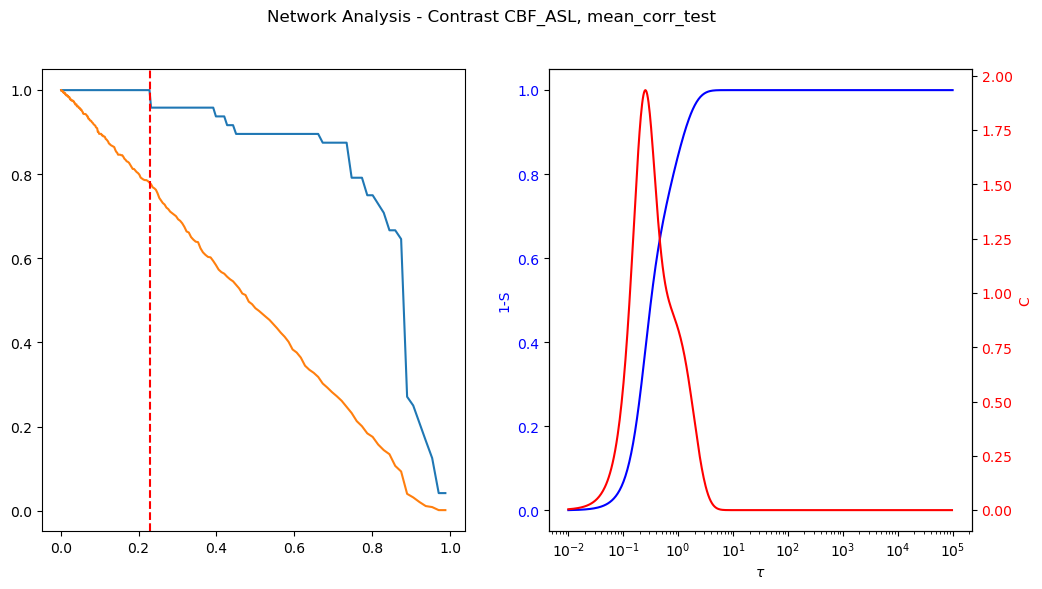

In [17]:
G, _ = build_correlation_network(corr_arr)
Th, Einf, Pinf = compute_threshold_stats(G)
cross_idx = np.where((Pinf[:-1] >= pinf_threshold) & (Pinf[1:] < pinf_threshold))[0]
if cross_idx.size > 0:
    i = cross_idx[0]
    x_cross = Th[i] + (Th[i+1] - Th[i]) * (Pinf[i] - pinf_threshold) / (Pinf[i] - Pinf[i+1])
    print("x value at crossing:", x_cross)
else:
    print("No crossing found.")
G, removednodes = build_correlation_network(corr_arr, threshold=max(float(x_cross), graph_threshold))
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
rho_m = lambda tau: rho_matrix(tau, L)
Sm1, Csp, VarL, t = entropy(spectrum)
#
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pos = nx.kamada_kawai_layout(G)
# nx.draw(G, pos=pos, ax=ax[0], alpha=0.7, with_labels=True)
ax[0].plot(Th, Pinf, label="Pinf")
ax[0].plot(Th, Einf, label="Pinf")
ax[0].axvline(x=max(float(x_cross), graph_threshold), color='red', linestyle='--', label="x_cross")
plot_entropy_and_C(ax[1], t, Sm1, Csp, color1="blue", color2="red")
fig.suptitle(f"Network Analysis - Contrast {dk}, {corr_arr_str}")
fig.savefig(path_neuroplots / f"netan_{dk}_{corr_arr_str}.png", bbox_inches='tight')
# plt.close('all')

In [18]:
#
dists = symmetrized_inverse_distance(1/max(spectrum), rho_m)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')
merge_distances = linkage_matrix[:, 2]
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]

In [19]:
#
old_leaf_colors = {}
num_logpoint = 8
min_tau_exponent = int(min(np.log10(linkage_matrix[:,2]).astype(int)))
max_tau_exponent = int(np.log10(linkage_matrix[:,2]).astype(int)[-2])
for i, dendro_threshold in enumerate(np.logspace(min_tau_exponent, max_tau_exponent, num_logpoint)):
    try:
        old_leaf_colors
    except NameError:
        old_leaf_colors = {}
    optimal_clusters = fcluster(linkage_matrix, t=dendro_threshold, criterion='distance')
    #
    fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4))
    dendro = dendrogram(linkage_matrix, ax=ax2[0],
                        color_threshold=dendro_threshold,
                        above_threshold_color='k',
                        orientation='right', labels=label_list)
    ax2[0].set_xscale('log')
    ax2[0].set_xlim(tmin)
    #
    # Update colors: keep the old color if the label exists; otherwise, use the new color.
    new_leaf_colors = {}
    for label, new_color in zip(dendro['ivl'], dendro['leaves_color_list']):
        if label in old_leaf_colors:
            new_leaf_colors[label] = old_leaf_colors[label]
        else:
            new_leaf_colors[label] = new_color

    leaf_label_colors = new_leaf_colors

    # Store colors for the next iteration.
    old_leaf_colors = new_leaf_colors.copy()
    #
    leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
    node_colors = [leaf_label_colors[label] for _,label in enumerate(label_list)]
    nx.draw(G, ax=ax2[1], node_color=node_colors, with_labels=True, alpha=0.7)
    fig2.savefig(path_neuroplots / f"dendrogram_{dk}_{corr_arr_str}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
    #
    fig, ax = plt.subplots(figsize=(12, 6))
    node_colors = [leaf_label_colors[i] if i in leaf_label_colors.keys() else 'white' for i in range(len(roi_indices))]
    cmap = ListedColormap(node_colors)
    plotting.plot_stat_map(atlas_img, bg_img=template, axes=ax, cmap=cmap, colorbar=False)
    fig.savefig(path_neuroplots / f"networkatlasmap_{dk}_{corr_arr_str}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
plt.close('all')

(np.float64(0.0),
 np.float64(470.0),
 np.float64(7.035179941190334e-08),
 np.float64(1.0396039603960396))

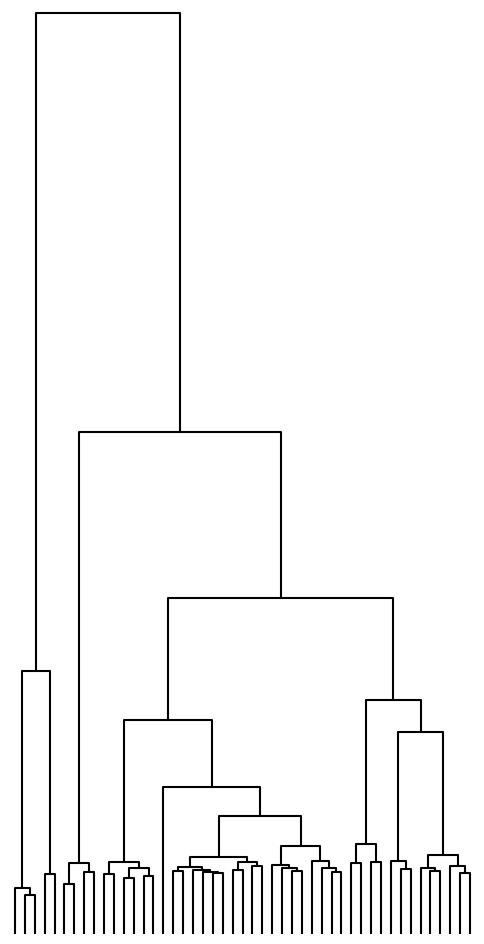

In [ ]:
# plt.figure(figsize=(6, 12))
# dendro = dendrogram(linkage_matrix, 
#                         color_threshold=1e-8,
#                         above_threshold_color='k',
#                         orientation='top', )
# plt.yscale('log')
# plt.ylim(bottom=tmin)
# plt.axis('off')